In [31]:
import pandas as pd, numpy as np, numpy.linalg as nl, inspect, seaborn as sns, plotly, plotly.express as px, pickle, plotly.graph_objects as go, sys
from tqdm import tqdm
from matplotlib.pyplot import *
from pathlib import Path
from sklearn.cluster import KMeans, AgglomerativeClustering
import kneed
from sklearn.metrics import silhouette_samples, adjusted_rand_score
from matplotlib import cm
from scipy.cluster.hierarchy import dendrogram, ward,single,complete

In [2]:
out_dir = Path('output')
res_dir = Path('results')
data_dir = Path('Data')
kmeans_dir = Path(res_dir,'kmeans')
kmeans_dir.mkdir(exist_ok=True)
agg_dir = Path(res_dir,'agglo')
agg_dir.mkdir(exist_ok=True)
save = True
STATE = 1

In [36]:
x = pd.read_csv(Path(data_dir,'X.csv'),header=None)
y = pd.read_csv(Path(data_dir, 'Y.csv'),header=None,names=['class'])
images = pd.read_csv(Path(data_dir,'images.csv'),header=None).values
sys.setrecursionlimit(y.shape[0])

In [4]:
def silhoutte_plot(x, y, plt_title='Silhouette Plot', rider='', save=True, outdir=''):
    cluster_labels = np.unique(y)
    n_clusters = cluster_labels.shape[0]
    silhouette_vals = silhouette_samples(x,y,metric='euclidean')
    y_ax_lower, y_ax_upper = 0, 0
    yticks_arr = []
    for i,c in enumerate(cluster_labels):
        c_silhouette_vals = silhouette_vals[y == c]
        c_silhouette_vals.sort()
        y_ax_upper += len(c_silhouette_vals)
        color = cm.jet(float(i)/n_clusters)
        barh(range(y_ax_lower,y_ax_upper),c_silhouette_vals,height=1.0,edgecolor='none',color=color)
        yticks_arr.append((y_ax_lower + y_ax_upper)/2.)
        y_ax_lower += len(c_silhouette_vals)
    silhouette_avg = np.mean(silhouette_vals)
    axvline(silhouette_avg,color="red",linestyle='--')
    yticks(yticks_arr, cluster_labels +1)
    ylabel('Cluster')
    xlabel('Silhouette Coefficient')
    title(plt_title)
    tight_layout()
    if save:
        savefig(Path(outdir,f'Silhouette_Plot{rider}.png'))
    show()
    return silhouette_vals



In [5]:
ks = np.arange(2,21)
kmean_SSE = [KMeans(n_clusters=k,random_state=STATE).fit(x).inertia_ for k in tqdm(ks)]
optimal_k = kneed.KneeLocator(ks,kmean_SSE,curve='convex',direction='decreasing').elbow

100%|██████████| 19/19 [00:31<00:00,  1.66s/it]


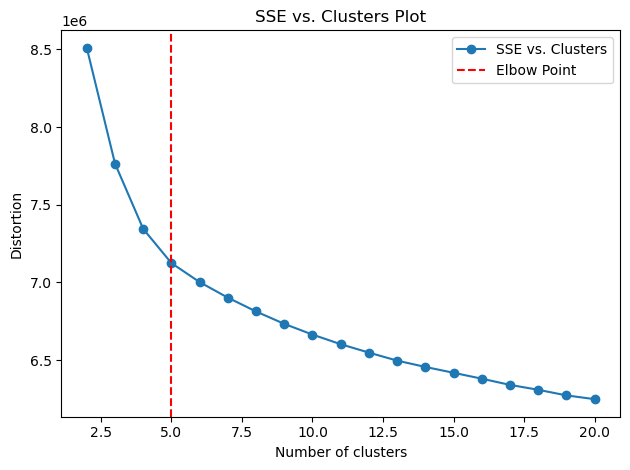

In [6]:
fig = plot(ks,kmean_SSE, marker='o',label='SSE vs. Clusters')
axvline(x=optimal_k,color='r',ls='--',label='Elbow Point')
xlabel('Number of clusters')
ylabel('Distortion')
title('SSE vs. Clusters Plot')
tight_layout()
legend()
if save:
    savefig(Path(kmeans_dir,'SSE_Cluster_Plot.png'))
show()

In [7]:
optimal_y = KMeans(n_clusters=optimal_k, random_state=STATE).fit_predict(x)

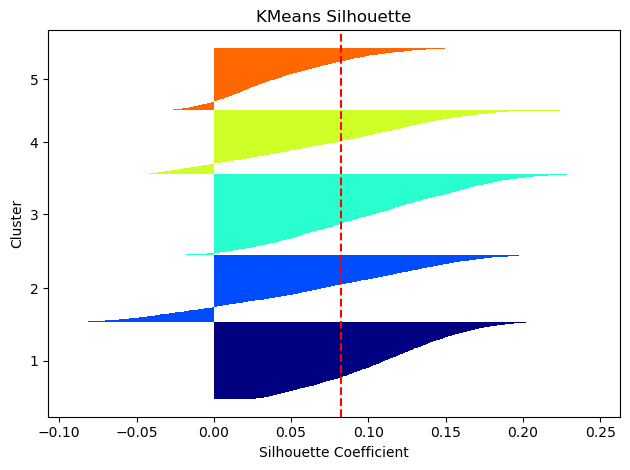

In [8]:
sil_vals = silhoutte_plot(x, optimal_y,plt_title='KMeans Silhouette',save=save, outdir=kmeans_dir)

In [24]:
km_res = pd.DataFrame(columns=['cluster','sil_score'])
km_res['cluster'] = optimal_y
km_res['sil_score'] = sil_vals
km_res['truth'] = y.values
center = km_res.groupby('cluster')['sil_score'].nlargest(5).reset_index().rename(columns={'level_1':'idx'})
#Double check that this works and that we want the closest to 0
edge = np.abs(km_res).groupby('cluster')['sil_score'].nsmallest(2).reset_index().rename(columns={'level_1':'idx'})


In [10]:
def display_image(idx, images,ax=None):
    if ax is not None:
        ax.imshow(images[idx].reshape(32,32,3))
    else:
        imshow(images[idx].reshape(32,32,3))

    

In [20]:
def draw_images(df, images, x,y, save=False, out_dir='', title=''):
    fig, axs = subplots(x,y)
    for i in range(x*y):
        ax = axs[i//y,i%y]
        display_image(int(df.iloc[i]['idx']),images, ax=ax)
        score = df.iloc[i]['sil_score']
        ax.set_title(f'{score:.2e}')
        if i%y == 0:
            cluster = int(df.iloc[i]['cluster'])
            ax.set_ylabel(f'Cluster {cluster+1}')
        ax.set_yticks([])
        ax.set_yticklabels([])
        ax.set_xticks([])
        ax.set_xticklabels([])
    fig.suptitle(f'{title}_Images With Score')
    tight_layout()
    if save:
        savefig(Path(out_dir,f'{title}_images.png'))
    show()



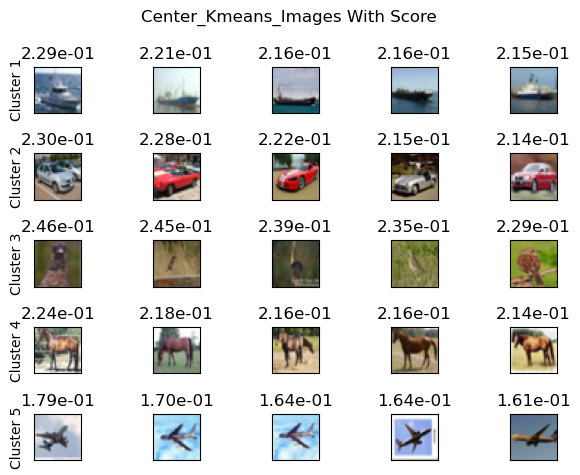

In [27]:
draw_images(center,images,5,5,save=True,out_dir=kmeans_dir, title='Center_Kmeans')

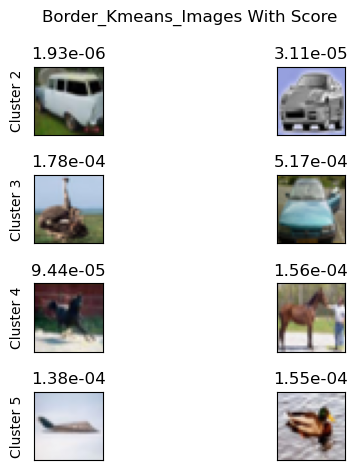

In [28]:
draw_images(edge.loc[edge['sil_score']<.001].reset_index(drop=True),images,4,2,save=True,out_dir=kmeans_dir, title='Border_Kmeans')

In [41]:
# linkage_array = ward(x)
def make_dendro(linkage_array,rider='',cluster_call=0,num_clusters=0,save=False):
    dendrogram(linkage_array)
    if cluster_call >0:
        ax = gca()
        bounds = ax.get_xbound()
        ax.plot(bounds,[cluster_call,cluster_call],'--',c='k')
        ax.text(bounds[1],cluster_call, f'{num_clusters} clusters',va='center',fontdict={'size':15})
    ylabel("Cluster Distance")
    title(f"{rider} Clustering Dendrogram")
    tight_layout()
    if save:
        savefig(Path(agg_dir,f'{rider}dendrogram.png'))
    show()
    # ax = gca()

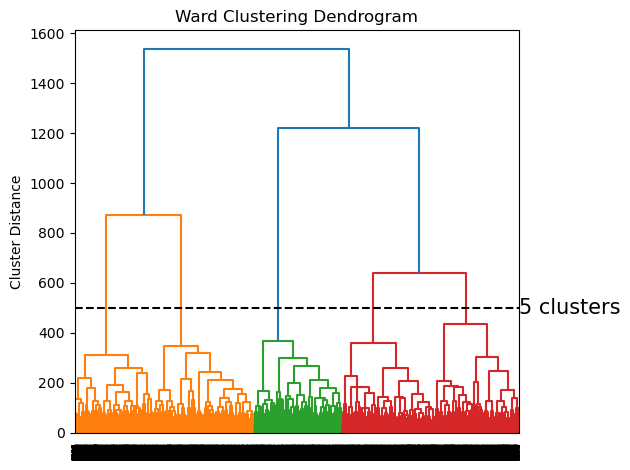

In [42]:
ward_linkage = ward(x)
make_dendro(ward_linkage,rider='Ward',save=save,cluster_call=500,num_clusters=5)

In [35]:
single_linkage = single(x)
make_dendro(single_linkage,rider='Single',save=save)

(9999, 4)

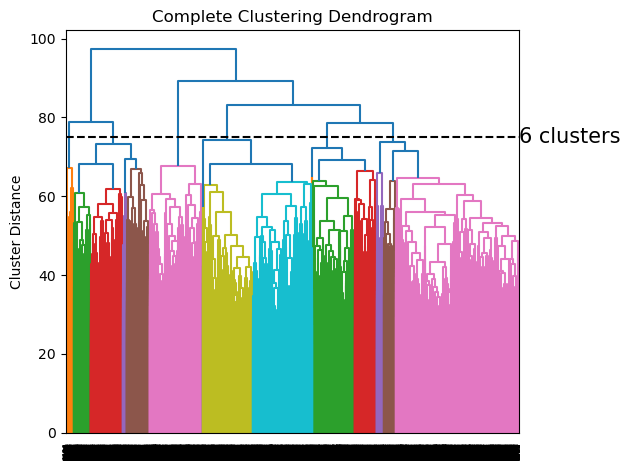

In [44]:
complete_linkage = complete(x)
make_dendro(complete_linkage,rider='Complete',save=save,cluster_call=75,num_clusters=6)

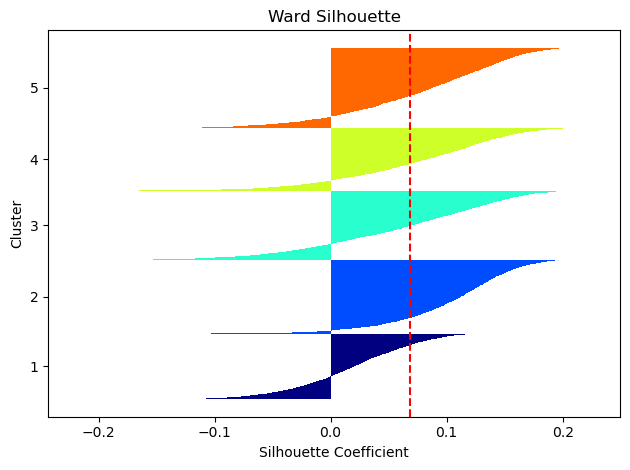

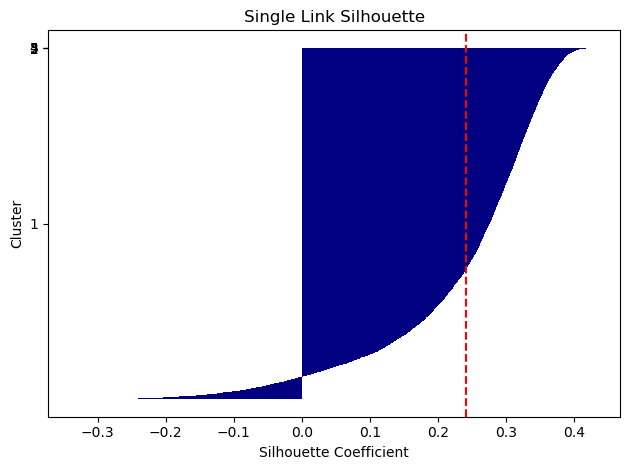

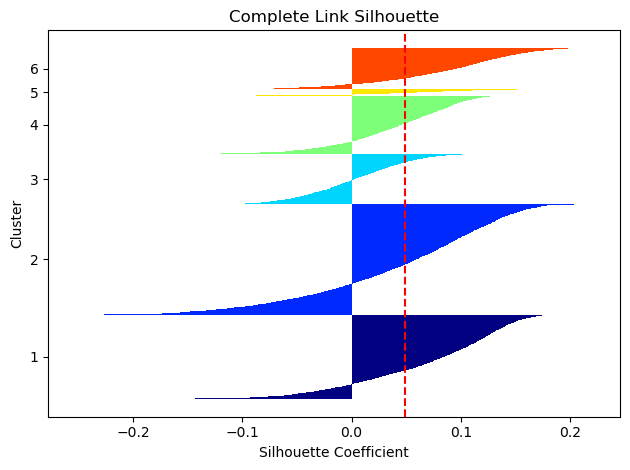

In [45]:
ward_y = AgglomerativeClustering(n_clusters=5,linkage='ward').fit_predict(x)
single_y = AgglomerativeClustering(n_clusters=5,linkage='single').fit_predict(x)
complete_y = AgglomerativeClustering(n_clusters=6,linkage='complete').fit_predict(x)

ward_agg = silhoutte_plot(x, ward_y,plt_title='Ward Silhouette',save=save, outdir=agg_dir, rider='_ward')
single_agg = silhoutte_plot(x, single_y,plt_title='Single Link Silhouette',save=save, outdir=agg_dir,rider='_single')
complete_agg = silhoutte_plot(x, complete_y,plt_title='Complete Link Silhouette',save=save, outdir=agg_dir,rider='_complete')

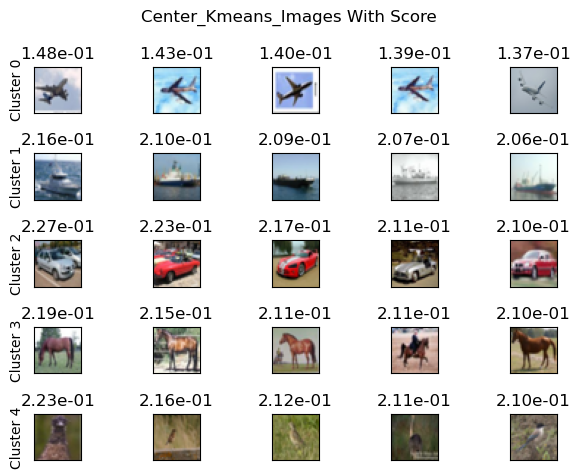

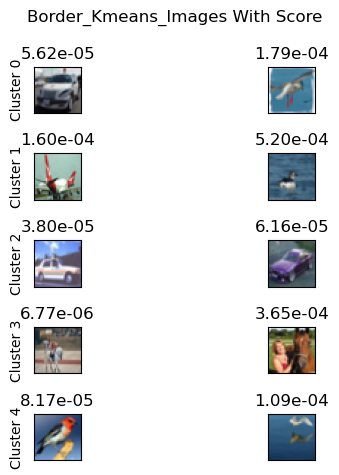

In [16]:
agg_res = pd.DataFrame(columns=['cluster','sil_score','truth'])
agg_res['cluster'] = ward_y
agg_res['sil_score'] = ward_agg
agg_res['truth'] = y.values
center = agg_res.groupby('cluster')['sil_score'].nlargest(5).reset_index().rename(columns={'level_1':'idx'})
#Double check that this works and that we want the closest to 0
edge = np.abs(agg_res).groupby('cluster')['sil_score'].nsmallest(2).reset_index().rename(columns={'level_1':'idx'})

draw_images(center,images,5,5,save=True,out_dir=kmeans_dir, title='Center_Kmeans')
draw_images(edge,images,5,2,save=True,out_dir=kmeans_dir, title='Border_Kmeans')

In [17]:
agg_ari = adjusted_rand_score(agg_res['cluster'].values,agg_res['truth'].values)
km_ari = adjusted_rand_score(km_res['cluster'].values,agg_res['truth'].values)

In [18]:
agg_ari

0.6867282741804425

In [19]:
km_ari

0.769198589579405

In [23]:
edge.loc[edge['sil_score']<.001].reset_index(drop=True)

,cluster,idx,sil_score
0,0,1680,0.000056
1,0,632,0.000179
2,1,3228,0.000160
3,1,2752,0.000520
4,2,5385,0.000038
5,2,3195,0.000062
6,3,4450,0.000007
7,3,285,0.000365
8,4,6660,0.000082
9,4,9519,0.000109


(9999, 4)